In [2]:
import time
from math import radians
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [3]:
def csv_to_df(csv_file):
    df = pd.read_csv(csv_file)
    return df

In [4]:
def get_centermost_point(cluster):
    cluster_weight = len(cluster)
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return (*centermost_point, cluster_weight)

In [5]:
def dbscan_reduce(df, epsilon, min_samples, x='lon', y='lat'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df[["lat", "lon"]].to_numpy()
    db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    print("Calculating clusters...")
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    clusters = clusters[clusters.apply(len) > 0]
    
    # find the point in each cluster that is closest to its centroid
    centermost_points_and_weights = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons, weights = zip(*centermost_points_and_weights)
    rs = pd.DataFrame({x:lons, y:lats, "weight": weights})
    rs.tail()
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs

In [6]:
def LLHtoECEF(lat: float, lon: float, alt: float = 0.0) -> Tuple[float, float, float]:
    # see http://www.mathworks.de/help/toolbox/aeroblks/llatoecefposition.html
    lat_rad = radians(lat)
    lon_rad = radians(lon)
    rad = np.float64(6378137.0)        # Radius of the Earth (in meters)
    f = np.float64(1.0/298.257223563)  # Flattening factor WGS84 Model
    cosLat = np.cos(lat_rad)
    sinLat = np.sin(lat_rad)
    FF     = (1.0-f)**2
    C      = 1/np.sqrt(cosLat**2 + FF * sinLat**2)
    S      = C * FF

    x = (rad * C + alt)*cosLat * np.cos(lon_rad)
    y = (rad * C + alt)*cosLat * np.sin(lon_rad)
    z = (rad * S + alt)*sinLat

    return (x, y, z)

In [7]:
coords_df = csv_to_df("lightning_lat_lon.csv")

In [8]:
# Run DBSCAN to cluster the coordinates into groups, then use geopy to find the centerpoint of those groups
"""
Good inputs:

eps_rad = 100 / kms_per_radian
min_samples = 80

eps_rad = 100 / kms_per_radian
min_samples = 200
clusters: 85

"""
kms_per_radian = 6371.0088
eps_rad = 150 / kms_per_radian
min_samples = 200
df_clustered = dbscan_reduce(coords_df, epsilon=eps_rad, min_samples=min_samples)

Number of clusters: 60
Calculating clusters...
Clustered 175,773 points down to 59 points, for 99.97% compression in 9.25 seconds.


In [9]:
print(df_clustered)

           lon        lat  weight
0   -61.094769 -30.728298   12788
1   -96.671844  34.960377   54711
2    11.162336  44.889629     947
3    18.584753   2.040506   16043
4   107.050652  20.577717     434
5   -72.531517  18.957514     330
6   -74.789291   7.862562    5458
7     9.284057  11.991840    2130
8    74.319489  31.680206    1499
9    32.787182  -1.039170     961
10   18.159679  43.061356     453
11  -53.716526 -11.130045     370
12  -50.255447 -21.462233     983
13  -11.227833   8.153018     991
14  -12.552281  14.330302    1657
15   -3.950653  10.752605    1328
16  -56.853889  -9.943567     565
17  -56.145962  -5.220495     971
18  -50.147293  -2.367059     628
19  -50.463764 -14.746348     504
20  -78.601715  21.641392     583
21   48.389706  29.275881     396
22  -60.855244  -1.100252     669
23  -44.759438 -15.424902     288
24  -42.501289 -19.198484     398
25   32.261887 -34.684544     301
26  100.890297   3.206693     617
27  -44.434021 -32.062359     325
28   -5.328909

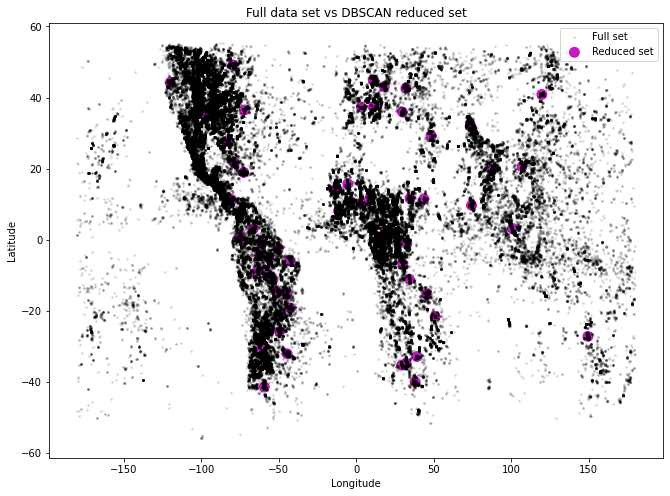

In [10]:
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_clustered['lon'], df_clustered['lat'], c='m', edgecolor='None', alpha=0.9, s=120)
df_scatter = ax.scatter(coords_df['lon'], coords_df['lat'], c='k', alpha=0.1, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

# For Blender

In [21]:
# Convert lat/lon to xyz.
df_clustered[["x", "y", "z"]] = df_clustered.apply(
    lambda x: LLHtoECEF(x[1], x[0]), axis=1, result_type="expand"
)

# Log normalize to bring down the variance (Some numbers too large and some too small) in the data.
df_clustered["log_scaled_weight"] = np.log(df_clustered["weight"])

# Normalize data between 0 and 1.
df_clustered["normalized_weight"] = (
    df_clustered["log_scaled_weight"] - df_clustered["log_scaled_weight"].min()
) / (df_clustered["log_scaled_weight"].max() - df_clustered["log_scaled_weight"].min())

# Remap the normalized data to a new range.
input_min = 0
input_max = 1
# Small, zoomed in
# output_min = 0.001
# output_max = 0.02
# Large, zoomed out
output_min = 0.005
output_max = 0.1
df_clustered["remapped_weight"] = df_clustered[["normalized_weight"]].apply(
    lambda x: np.interp(x, [input_min, input_max], [output_min, output_max])[0], axis=1
)
print(df_clustered[["weight", "log_scaled_weight", "normalized_weight", "remapped_weight"]])
t = list(df_clustered["remapped_weight"])
print(list(reversed(sorted(t)))[:15])


    weight  log_scaled_weight  normalized_weight  remapped_weight
0    12788           9.456263           0.742839         0.075570
1    54711          10.909820           1.000000         0.100000
2      947           6.853299           0.282327         0.031821
3    16043           9.683028           0.782958         0.079381
4      434           6.073045           0.144286         0.018707
5      330           5.799093           0.095819         0.014103
6     5458           8.604838           0.592206         0.061260
7     2130           7.663877           0.425733         0.045445
8     1499           7.312553           0.363578         0.039540
9      961           6.867974           0.284923         0.032068
10     453           6.115892           0.151866         0.019427
11     370           5.913503           0.116060         0.016026
12     983           6.890609           0.288928         0.032448
13     991           6.898715           0.290362         0.032584
14    1657

In [22]:
# print(df_clustered)
coords_with_weights = [tuple(x) for x in df_clustered[["x", "y", "z", "remapped_weight"]].to_numpy()]
print(coords_with_weights)

[(2652423.775912803, -4803820.639059836, -3240036.5483028498, 0.07556970357955364), (-607977.7595158016, -5197508.69283452, 3634265.198710633, 0.1), (4440630.707178486, 876235.4369791322, 4478666.995822263, 0.031821062437593604), (6041730.103169326, 2031477.1258331167, 225580.7788285463, 0.07938100474431846), (-1751578.3293114828, 5711092.1783289155, 2227686.1868784563, 0.018707133720054277), (1811388.1956140653, -5756027.857875901, 2058902.2413853859, 0.014102757648425557), (1657800.8865282955, -6097216.761967598, 866725.3157375577, 0.061259599111220406), (6158111.892704921, 1006670.0454127154, 1316519.6051459045, 0.04544464740587022), (1468329.6323926505, 5230577.902207935, 3330307.356471551, 0.03953986325607095), (5361145.801547741, 3453325.4221807234, -114899.26056406391, 0.03206771405002005), (4434831.230162033, 1454640.8417930964, 4332484.320236998, 0.019427283641085823), (3703928.747542397, -5045337.389984717, -1223123.6836042767, 0.016025680331058462), (3796894.8342041564, -456